# 1.1 Regression
### - 1. Generate regression model for California housing dataset with keras functional API
### - 2. with your own MLP model (# of hidden layers, nodes, activation function, …)
### - 3. Print train/validation loss of your own model

In [64]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [65]:
housing_data = fetch_california_housing()
print(housing_data.keys())
print(housing_data.feature_names)

dict_keys(['data', 'target', 'frame', 'target_names', 'feature_names', 'DESCR'])
['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


In [66]:
X = housing_data['data']
y = housing_data['target']
print("X shape : ", X.shape)
print("y shape : ", y.shape)

X shape :  (20640, 8)
y shape :  (20640,)


In [67]:
# Scaling은 데이터들의 비율을 그대로 유지하는 상태에서 범위만 바꾼다
# 평균이 0(zero-mean)이면서 단위 분산(unit variance)의 분포를 가진 데이터의 입력을 필요로할 때가 있다.
#  특히, 회귀 모델의 알고리즘이, 이러한 정규분포를 가진 작은 크기의 샘플을 필요로 할 수 있다.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(X_scaled.shape)

(20640, 8)


In [68]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [69]:
print("X_train Shape : ", X_train.shape)
print("X_test Shape : ", X_test.shape)
print("y_train Shape : ", y_train.shape)
print("y_test Shape : ", y_test.shape)

X_train Shape :  (16512, 8)
X_test Shape :  (4128, 8)
y_train Shape :  (16512,)
y_test Shape :  (4128,)


In [70]:
# Multilayer Perceptron Model 생성
# nn.Linear(입력 차원 수, 출력 차원 수)를 통해 모델의 layer마다의 node수를 설정

class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_layers, nodes):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_dim, nodes[0]))
        self.layers.append(nn.ReLU())
        for i in range(1, hidden_layers):
            self.layers.append(nn.Linear(nodes[i-1], nodes[i]))
            self.layers.append(nn.ReLU())
        self.layers.append(nn.Linear(nodes[-1], output_dim))

    # 입력 데이터 x를 받아 MLP모델을 통과시켜 출력값을 계싼
    # x = layer(x)는 현재의 layer을 x에 적용한 이후 x에 다시 할당하여 출력층까지 도달
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


In [71]:
# (X_train.shape[1] = 8), (output_dim = 1), (hidden_layers = 4, nodes = [8, 16, 32, 64]) 
model = MLP(X_train.shape[1], 1, 4, [8, 16, 32, 64])
criterion = nn.MSELoss()

In [72]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [73]:
num_epochs = 100
batch_size = 32

In [74]:
train_losses = []
val_losses = []

In [75]:
for epoch in range(num_epochs):
    # Train the model on batches
    for i in range(0, len(X_train), batch_size):
        # Extract batch data
        batch_X = torch.tensor(X_train[i:i+batch_size], dtype=torch.float32)
        batch_y = torch.tensor(y_train[i:i+batch_size], dtype=torch.float32).view(-1, 1)
        
        # Forward pass
        y_pred = model(batch_X)
        loss = criterion(y_pred, batch_y)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # Evaluate the model on training and validation sets
    with torch.no_grad():
        train_X = torch.tensor(X_train, dtype=torch.float32)
        train_y = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
        train_loss = criterion(model(train_X), train_y)
        train_losses.append(train_loss.item())
        
        val_X = torch.tensor(X_test, dtype=torch.float32)
        val_y = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)
        val_loss = criterion(model(val_X), val_y)
        val_losses.append(val_loss.item())
        
    # Print the train and validation losses
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss.item()}, Test Loss: {val_loss.item()}')

Epoch 1/100, Train Loss: 0.45979979634284973, Test Loss: 0.48237404227256775
Epoch 2/100, Train Loss: 0.39804568886756897, Test Loss: 0.42527422308921814
Epoch 3/100, Train Loss: 0.381659597158432, Test Loss: 0.4083160161972046
Epoch 4/100, Train Loss: 0.37479090690612793, Test Loss: 0.4007050693035126
Epoch 5/100, Train Loss: 0.36860716342926025, Test Loss: 0.3944645822048187
Epoch 6/100, Train Loss: 0.3626815378665924, Test Loss: 0.38696396350860596
Epoch 7/100, Train Loss: 0.35665562748908997, Test Loss: 0.37828314304351807
Epoch 8/100, Train Loss: 0.3496516942977905, Test Loss: 0.37105676531791687
Epoch 9/100, Train Loss: 0.34250888228416443, Test Loss: 0.36156919598579407
Epoch 10/100, Train Loss: 0.33580875396728516, Test Loss: 0.35376301407814026
Epoch 11/100, Train Loss: 0.3296319246292114, Test Loss: 0.345797598361969
Epoch 12/100, Train Loss: 0.32546159625053406, Test Loss: 0.3395528197288513
Epoch 13/100, Train Loss: 0.3174940049648285, Test Loss: 0.3326459527015686
Epoch 14

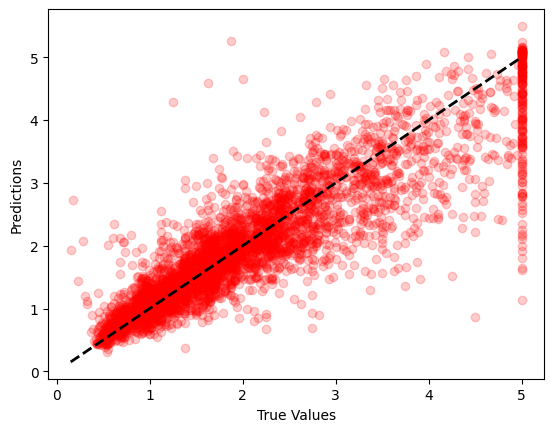

In [80]:
import matplotlib.pyplot as plt

# Make predictions on test set
with torch.no_grad():
    y_pred = model(torch.tensor(X_test, dtype=torch.float32))
y_pred = y_pred.detach().numpy()

# Plot predicted and true values
plt.scatter(y_test, y_pred, color='red', alpha=0.2)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=2) # Draw diagonal line
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()
